In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

In [6]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# inspecting the Measurement table
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x28e4aa5b790>,
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0,
 'station': 'USC00519397'}

In [11]:
# inspecting the Station table
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x28e4aa643d0>,
 'id': 1,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'elevation': 3.0,
 'latitude': 21.2716}

# Exploratory Precipitation Analysis

In [12]:
pd.read_sql('select * from measurement',engine)

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


In [13]:
pd.read_sql('select * from station',engine)

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [14]:
# Find the most recent date in the data set.
latestdatestr = session.query(measurement.date).order_by(measurement.date.desc()).first()
latestdatestr 

('2017-08-23')

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
latestdate = dt.datetime.strptime(latestdatestr[0], '%Y-%m-%d')
twelve_months_qry = dt.date(latestdate.year -1, latestdate.month, latestdate.day)
twelve_months_qry

datetime.date(2016, 8, 23)

In [16]:
# Perform a query to retrieve the data and precipitation scores

precipitationqry = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= twelve_months_qry).all()

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

precipitation_df = pd.DataFrame(precipitationqry, columns=['Date','Precipitation'])
precipitation_df = precipitation_df.dropna(how='any') # clean up non value entries
precipitation_df = precipitation_df.sort_values(["Date"], ascending=True)
precipitation_df = precipitation_df.set_index("Date")
precipitation_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


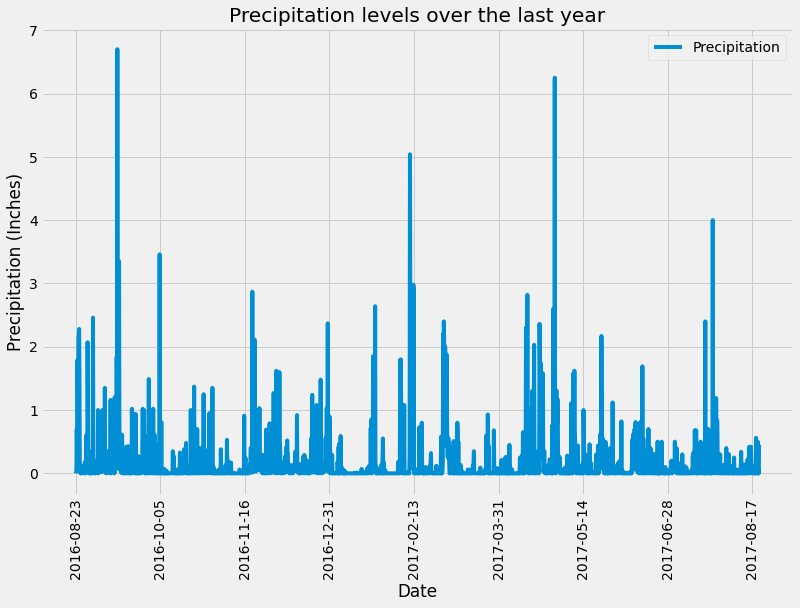

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(rot=90, figsize=(12,8))
plt.ylabel('Precipitation (Inches)')
plt.title("Precipitation levels over the last year")
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number stations in the dataset
print(f" There are {session.query(measurement).group_by(measurement.station).count()} stations in the dataset.")

 There are 9 stations in the dataset.


In [21]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
engine.execute("SELECT station, COUNT(station) AS 'Station' FROM measurement GROUP BY station ORDER BY COUNT(station) DESC").fetchall()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

print(f"""
Temperature Analysis USC00519281 for {latestdatestr}
------------------------------------------------
Station    Temperature 
{session.query(func.min(measurement.tobs)).filter(measurement.station=='USC00519281').all()}  Lowest tempeture recorded in the last 12 months
{session.query(func.max(measurement.tobs)).filter(measurement.station=='USC00519281').all()}  Highest tempeture recorded in the last 12 months
{session.query(func.avg(measurement.tobs)).filter(measurement.station=='USC00519281').all()}  Average temperature in the last 12 months

""")


Temperature Analysis USC00519281 for ('2017-08-23',)
------------------------------------------------
Station    Temperature 
[(54.0,)]  Lowest tempeture recorded in the last 12 months
[(85.0,)]  Highest tempeture recorded in the last 12 months
[(71.66378066378067,)]  Average temperature in the last 12 months




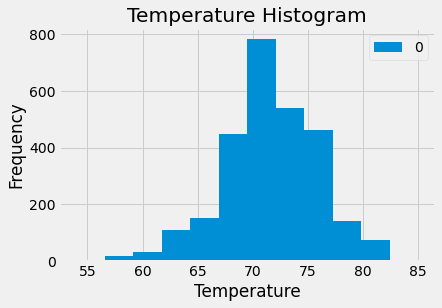

In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

engine.execute("SELECT station, COUNT(tobs) AS 'Temperatures' FROM measurement GROUP BY station ORDER BY COUNT(tobs) DESC").fetchall()
temp_query=engine.execute("SELECT tobs FROM measurement WHERE station='USC00519281' ORDER BY tobs").fetchall()
temp_query_df=pd.DataFrame(temp_query)
temp_query_df.plot(kind='hist',bins=12)
plt.title("Temperature Histogram")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close session

In [24]:
# Close Session
session.close()